In [1]:
from __future__ import print_function
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import pdb

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from test_tube import Experiment  
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
batch_size = 256 # input batch size for training
epochs = 100       # number of epochs to train
lr = 0.1      # learning rate
momentum = 0.9
weight_decay = 5e-4

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = datasets.CIFAR10(root='/scratch/vr1059/cifar10', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='/scratch/vr1059/cifar10', train=False, download=True, transform=data_transform)

# train_dist_sampler = torch.utils.data.distributed.DistributedSampler(trainset)
# test_dist_sampler = torch.utils.data.distributed.DistributedSampler(testset)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


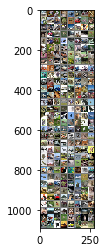

In [4]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.imshow(np.transpose(torchvision.utils.make_grid(images), (1, 2, 0)) * 0.5 + 0.5)

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, filter_size):
        super(BasicBlock, self).__init__()
        
        padding = (int)((filter_size-1)/2)
        self.layers = nn.Sequential(OrderedDict([
          ('conv', nn.Conv2d(in_channels, out_channels, kernel_size=filter_size, stride=1, padding=padding, bias=False)),
          ('batchnorm', nn.BatchNorm2d(out_channels)),
          ('relu', nn.ReLU(inplace=True))
        ]))
        
    def forward(self, x):
        return self.layers(x)
    
    
class GlobalAveragePooling(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling, self).__init__()

    def forward(self, feat):
        num_channels = feat.size(1)
        return F.avg_pool2d(feat, (feat.size(2), feat.size(3))).view(-1, num_channels)
    

# Let's just do 3 blocks for now

class NetworkInNetwork(pl.LightningModule):

    def __init__(self):
        super(NetworkInNetwork, self).__init__()
        
        # Hard-coded to run first expermient, will make modular afterwards. 
        
        num_classes = 4
        num_blocks = 3
        
        n_channels = 192
        blocks = []
        
        blocks.append(nn.Sequential(OrderedDict([
            ('b1_convb1', BasicBlock(3, 192, 5)),
            ('b1_convb2', BasicBlock(192, 160, 1)),
            ('b1_convb3', BasicBlock(160, 96, 1)),
            ('b1_maxpool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        ])))
        
        blocks.append(nn.Sequential(OrderedDict([
            ('b2_convb1', BasicBlock(96, n_channels, 5)),
            ('b2_convb2', BasicBlock(n_channels, n_channels, 1)),
            ('b2_convb3', BasicBlock(n_channels, n_channels, 1)),
            ('b2_avgpool', nn.AvgPool2d(kernel_size=3, stride=2, padding=1))
        ])))
        
        blocks.append(nn.Sequential(OrderedDict([
            ('b3_convb1', BasicBlock(n_channels, n_channels, 3)),
            ('b3_convb2', BasicBlock(n_channels, n_channels, 1)),
            ('b3_convb3', BasicBlock(n_channels, n_channels, 1)),
            ('global_avgpool', GlobalAveragePooling()),
            ('classifier', nn.Linear(n_channels, num_classes)),
        ])))
        
        self.blocks = nn.ModuleList(blocks)    
        
        
    def forward(self, x):
        # input has shape [bs, 3, 32, 32]     
        for i, block in enumerate(self.blocks):
            x = block(x) 
        
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'loss': F.cross_entropy(y_hat, y)}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        
        pred = y_hat.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct = pred.eq(y.data.view_as(pred)).sum()
        
        return {'val_loss': F.cross_entropy(y_hat, y), 'correct': correct, 'bs': y.shape[0]}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_set_size = torch.tensor([x['bs'] for x in outputs]).sum()
        avg_accuracy = torch.stack([x['correct'] for x in outputs]).sum().item()/(1. * val_set_size.item())
        return {'avg_val_loss': avg_loss, 'avg_val_acc': 100*avg_accuracy}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        return torch.optim.SGD(self.parameters(), lr=lr)

    @pl.data_loader
    def tng_dataloader(self):
        return train_loader

    @pl.data_loader
    def val_dataloader(self):
        return test_loader
    
    

In [6]:
class PretrainedRotNetClassifier(pl.LightningModule):

    def __init__(self, pretrained_model):
        super(PretrainedRotNetClassifier, self).__init__()
        
        self.layers = nn.Sequential(OrderedDict([
            ('RotNet_B3', pretrained_model),
            ('flatten', nn.Flatten()),
            ('linear_1', nn.Linear(192 * 8 * 8, 200)),
            ('batchnorm', nn.BatchNorm1d(200)),
            ('relu', nn.ReLU(inplace=True)),
            ('linear_2', nn.Linear(200, 200)),
            ('batchnorm', nn.BatchNorm1d(200)),
            ('relu', nn.ReLU(inplace=True)),
            ('classifier', nn.Linear(200, 10))
        ])) 
        
        
    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'loss': F.cross_entropy(y_hat, y)}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        
        pred = y_hat.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct = pred.eq(y.data.view_as(pred)).sum()
        
        return {'val_loss': F.cross_entropy(y_hat, y), 'correct': correct, 'bs': y.shape[0]}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_set_size = torch.tensor([x['bs'] for x in outputs]).sum()
        avg_accuracy = torch.stack([x['correct'] for x in outputs]).sum().item()/(1. * val_set_size.item())
        return {'avg_val_loss': avg_loss, 'avg_val_acc': 100*avg_accuracy}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        return torch.optim.SGD(filter(lambda p: p.requires_grad, self.parameters()), lr=lr, momentum=momentum, weight_decay=weight_decay)

    @pl.data_loader
    def tng_dataloader(self):
        return train_loader

    @pl.data_loader
    def val_dataloader(self):
        return test_loader

In [7]:
model = NetworkInNetwork()
model.load_state_dict(torch.load("best_rot_model_100/_ckpt_epoch_61.ckpt")['state_dict'])
for param in model.parameters():
    param.requires_grad = False

In [10]:
classifier = PretrainedRotNetClassifier(pretrained_model=model)
exp = Experiment(save_dir='./rot_classifier_logs')
trainer = Trainer(experiment=exp, gpus=[0], max_nb_epochs=epochs) 

VISIBLE GPUS: '0'
gpu available: True, used: True


In [9]:
trainer.fit(model) 

  0%|          | 0/5 [00:00<?, ?it/s]

                                   Name                  Type   Params
0                                blocks            ModuleList  1004484
1                              blocks.0            Sequential    61376
2                    blocks.0.b1_convb1            BasicBlock    14784
3             blocks.0.b1_convb1.layers            Sequential    14784
4        blocks.0.b1_convb1.layers.conv                Conv2d    14400
5   blocks.0.b1_convb1.layers.batchnorm           BatchNorm2d      384
6        blocks.0.b1_convb1.layers.relu                  ReLU        0
7                    blocks.0.b1_convb2            BasicBlock    31040
8             blocks.0.b1_convb2.layers            Sequential    31040
9        blocks.0.b1_convb2.layers.conv                Conv2d    30720
10  blocks.0.b1_convb2.layers.batchnorm           BatchNorm2d      320
11       blocks.0.b1_convb2.layers.relu                  ReLU        0
12                   blocks.0.b1_convb3            BasicBlock    15552
13    

 20%|██        | 1/5 [00:00<00:00,  8.23it/s]

RuntimeError: CUDA error: device-side assert triggered